In [ ]:
# import sys
# import asyncio
# from dotenv import load_dotenv

# load_dotenv()

# # Fix for Windows issues in Jupyter notebooks
# if sys.platform == "win32":
#     # 1. Use ProactorEventLoop for subprocess support
#     if not isinstance(asyncio.get_event_loop_policy(), asyncio.WindowsProactorEventLoopPolicy):
#         asyncio.set_event_loop_policy(asyncio.WindowsProactorEventLoopPolicy())
    
#     # 2. Redirect stderr to avoid fileno() error when launching MCP servers
#     if "ipykernel" in sys.modules:
#         sys.stderr = sys.__stderr__


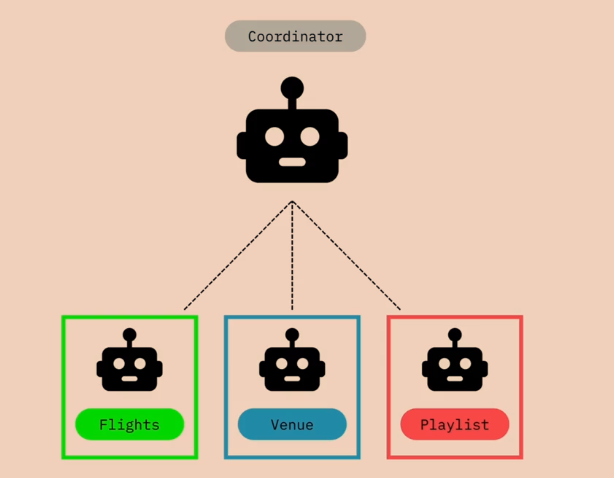
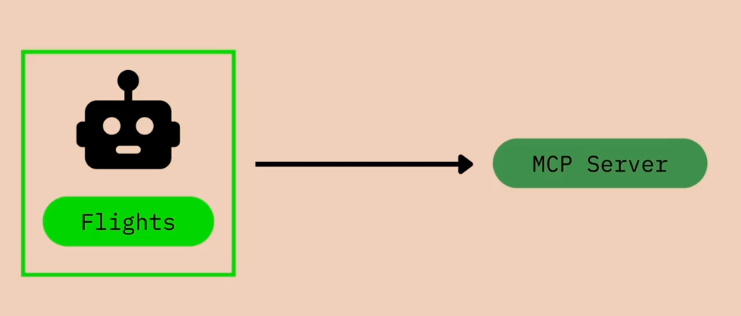
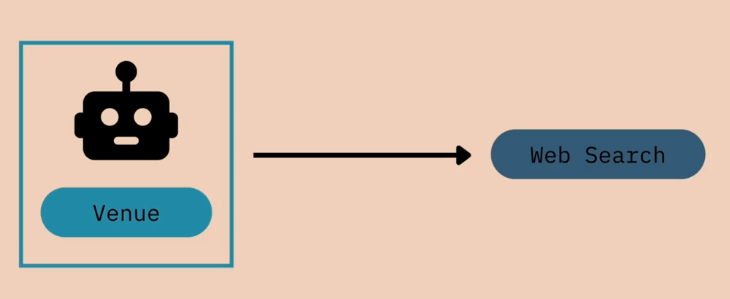
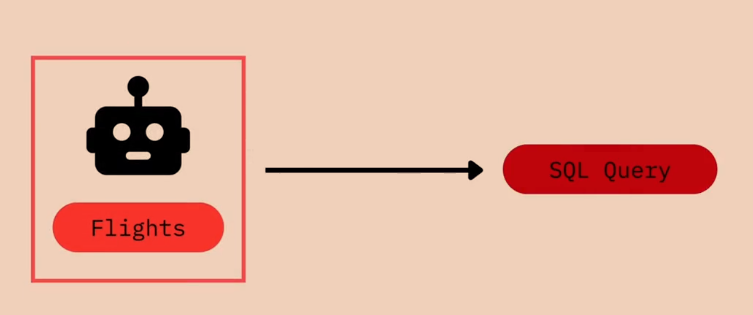
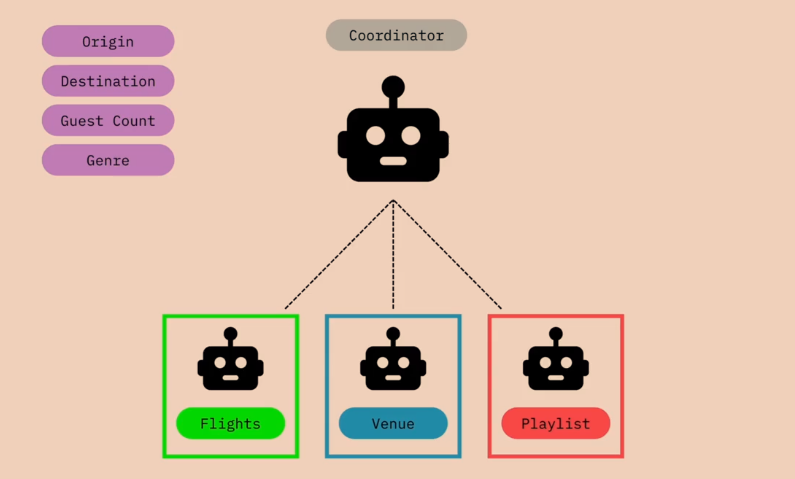
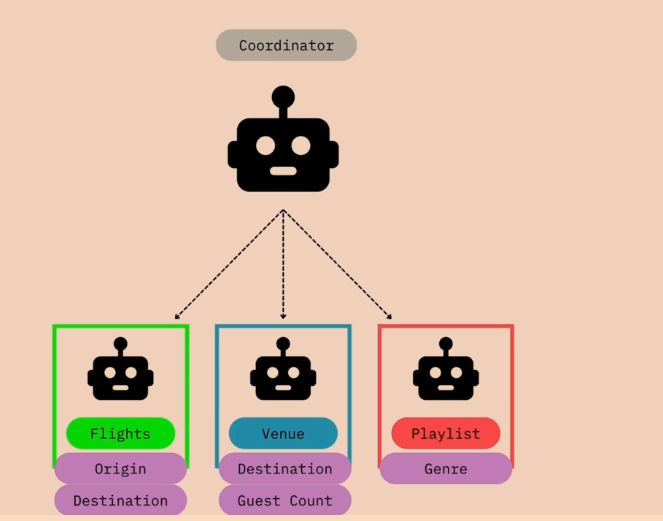

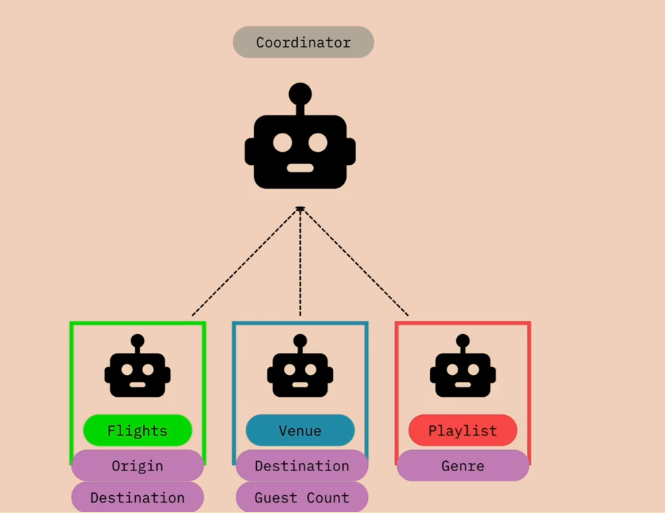

In [43]:
import sys
import asyncio
from dotenv import load_dotenv

load_dotenv()

# Fix for Windows issues in Jupyter notebooks
if sys.platform == "win32":
    # 1. Use ProactorEventLoop for subprocess support
    if not isinstance(asyncio.get_event_loop_policy(), asyncio.WindowsProactorEventLoopPolicy):
        asyncio.set_event_loop_policy(asyncio.WindowsProactorEventLoopPolicy())
    
    # 2. Redirect stderr to avoid fileno() error when launching MCP servers
    if "ipykernel" in sys.modules:
        sys.stderr = sys.__stderr__


## Setup Tools


In [44]:
from langchain_mcp_adapters.client import MultiServerMCPClient

client = MultiServerMCPClient(
    {
        "travel_server": {
                "transport": "streamable_http",
                "url": "https://mcp.kiwi.com"
            }
    }
)

tools = await client.get_tools()

In [45]:
from typing import Dict, Any
from tavily import TavilyClient
from langchain.tools import tool

tavily_client = TavilyClient()

@tool
def web_search(query: str) -> Dict[str, Any]:

    """Search the web for information"""

    return tavily_client.search(query)

In [46]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///resources/Chinook.db")

@tool
def query_playlist_db(query: str) -> str:

    """Query the database for playlist information"""

    try:
        return db.run(query) # type: ignore
    except Exception as e:
        return f"Error querying database: {e}"

## Create State

In [47]:
from langchain.agents import AgentState

class WeddingState(AgentState):
    origin: str
    destination: str
    guest_count: str
    genre: str

## Create Subagents


In [48]:
from langchain.chat_models import init_chat_model
model = init_chat_model(model="qwen/qwen3-32b",
                        model_provider="groq",
                        temperature = 0,
                        max_retries=3,
                        timeout=60,
                        max_tokens=512
                        )

In [49]:
from langchain.agents import create_agent

# Travel agent
travel_agent = create_agent(
    model=model,
    tools=tools,
    system_prompt="""
    You are a travel agent. Search for flights to the desired destination wedding location.
    You are not allowed to ask any more follow up questions, you must find the best flight options based on the following criteria:
    - Price (lowest, economy class)
    - Duration (shortest)
    - Date (time of year which you believe is best for a wedding at this location)
    
    IMPORTANT: Today is December 20, 2025. You MUST pick a departure date in the FUTURE (e.g., in 2026).
    To make things easy, only look for one ticket, one way. Do not provide a return date.
    Ensure all dates are in dd/mm/yyyy format.
    
    You may need to make multiple searches to iteratively find the best options.
    You will be given no extra information, only the origin and destination. It is your job to think critically about the best options.
    Once you have found the best options, let the user know your shortlist of options.
    """
)

In [50]:
# Venue agent
venue_agent = create_agent(
    model=model,
    tools=[web_search],
    system_prompt="""
    You are a venue specialist. Search for venues in the desired location, and with the desired capacity.
    You are not allowed to ask any more follow up questions, you must find the best venue options based on the following criteria:
    - Price (lowest)
    - Capacity (exact match)
    - Reviews (highest)
    You may need to make multiple searches to iteratively find the best options.
    """
)

In [51]:
# Playlist agent
playlist_agent = create_agent(
    model=model,
    tools=[query_playlist_db],
    system_prompt="""
    You are a playlist specialist. Query the sql database and curate the perfect playlist for a wedding given a genre.
    Once you have your playlist, calculate the total duration and cost of the playlist, each song has an associated price.
    If you run into errors when querying the database, try to fix them by making changes to the query.
    Do not come back empty handed, keep trying to query the db until you find a list of songs.
    You may need to make multiple queries to iteratively find the best options.
    """
)

## Main Coordinator


In [52]:
from langchain.tools import ToolRuntime
from langchain.messages import HumanMessage, ToolMessage
from langgraph.types import Command
from typing import Annotated
from langchain_core.tools import InjectedToolArg

# @tool
# async def search_flights(runtime: Annotated[ToolRuntime, InjectedToolArg]) -> str:
#     """Travel agent searches for flights to the desired destination wedding location."""
#     origin = runtime.state["origin"]
#     destination = runtime.state["destination"]
#     response = await travel_agent.ainvoke({"messages": [HumanMessage(content=f"Find flights from {origin} to {destination}")]})
#     return response['messages'][-1].content

# @tool
# def search_venues(runtime: Annotated[ToolRuntime, InjectedToolArg]) -> str:
#     """Venue agent chooses the best venue for the given location and capacity."""
#     destination = runtime.state["destination"]
#     capacity = runtime.state["guest_count"]
#     query = f"Find wedding venues in {destination} for {capacity} guests"
#     response = venue_agent.invoke({"messages": [HumanMessage(content=query)]})
#     return response['messages'][-1].content

# @tool
# def suggest_playlist(runtime: Annotated[ToolRuntime, InjectedToolArg]) -> str:
#     """Playlist agent curates the perfect playlist for the given genre."""
#     genre = runtime.state["genre"]
#     query = f"Find {genre} tracks for wedding playlist"
#     response = playlist_agent.invoke({"messages": [HumanMessage(content=query)]})
#     return response['messages'][-1].content



@tool
async def search_flights(runtime: Annotated[ToolRuntime, InjectedToolArg]) -> str:
    """Travel agent searches for flights to the desired destination wedding location."""
    origin = runtime.state["origin"]
    destination = runtime.state["destination"]
    response = await travel_agent.ainvoke({"messages": [HumanMessage(content=f"Find flights from {origin} to {destination}")]})
    return str(response['messages'][-1].content)[:1000]

@tool
def search_venues(runtime: Annotated[ToolRuntime, InjectedToolArg]) -> str:
    """Venue agent chooses the best venue for the given location and capacity."""
    destination = runtime.state["destination"]
    capacity = runtime.state["guest_count"]
    query = f"Find wedding venues in {destination} for {capacity} guests"
    response = venue_agent.invoke({"messages": [HumanMessage(content=query)]})
    return str(response['messages'][-1].content)[:1000]

@tool
def suggest_playlist(runtime: Annotated[ToolRuntime, InjectedToolArg]) -> str:
    """Playlist agent curates the perfect playlist for the given genre."""
    genre = runtime.state["genre"]
    query = f"Find {genre} tracks for wedding playlist"
    response = playlist_agent.invoke({"messages": [HumanMessage(content=query)]})
    # return response['messages'][-1].content
    return str(response['messages'][-1].content)[:1000]






@tool
def update_state(origin: str, destination: str, guest_count: str, genre: str, runtime: Annotated[ToolRuntime, InjectedToolArg]) -> str:
    """Update the state when you know all of the values: origin, destination, guest_count, genre"""
    return Command(update={
        "origin": origin, 
        "destination": destination, 
        "guest_count": guest_count, 
        "genre": genre, 
        "messages": [ToolMessage("Successfully updated state", tool_call_id=runtime.tool_call_id)]}
        ) # type: ignore


In [53]:
from langchain.agents import create_agent

coordinator = create_agent(
    model=model,
    tools=[search_flights, search_venues, suggest_playlist, update_state],
    state_schema=WeddingState,
    system_prompt="""
    You are a wedding coordinator. Delegate tasks to your specialists for flights, venues and playlists.
    
    CRITICAL: You must first call 'update_state' with the origin, destination, guest_count, and genre before calling any other tools.
    The other tools (search_flights, search_venues, suggest_playlist) depend on the state being updated first.
    
    Once you have called 'update_state', you can then delegate the tasks to the specialists.
    Once you have received their answers, coordinate the perfect wedding for me.
    """
)


## Test


In [54]:
from langchain.messages import HumanMessage

response = await coordinator.ainvoke(
    {
        "messages": [HumanMessage(content="I'm from India and I'd like a wedding in Paris for 100 guests, jazz-genre")],
    }
)

In [55]:
from pprint import pprint

pprint(response)

{'destination': 'Paris',
 'genre': 'jazz',
 'guest_count': '100',
 'messages': [HumanMessage(content="I'm from India and I'd like a wedding in Paris for 100 guests, jazz-genre", additional_kwargs={}, response_metadata={}, id='0e6ced93-7f9b-4fa9-8a9e-8b4ac521c816'),
              AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, let's see. The user is from India and wants a wedding in Paris for 100 guests with a jazz genre. First, I need to update the state with all the necessary information. The origin is India, destination is Paris, guest count is 100, and the genre is jazz. I should call the update_state function with these parameters. Once that's done, I can delegate the tasks to the specialists. The flight specialist can look for flights from India to Paris, the venue specialist can find a suitable venue in Paris that can accommodate 100 people, and the playlist specialist can create a jazz playlist for the wedding. I need to make sure each specialist gets the ri

In [56]:
print(response["messages"][-1].content)

Your dream wedding in Paris is all set! Here's the coordinated plan:

**Flights:**  
We've secured direct Air France flights from Delhi to Paris (AI 890) with premium economy seats for all 100 guests, departing 2 days before the event.  

**Venue:**  
The Eiffel Tower's private rooftop terrace (capacity: 150 guests) will host your jazz-themed celebration. Includes:  
- String lighting with jazz-themed projections  
- Champagne reception area  
- Dance floor with Parisian skyline views  

**Playlist:**  
Curated jazz setlist featuring:  
1. "Take Five" by Dave Brubeck  
2. "Fly Me to the Moon" by Frank Sinatra  
3. "La Vie En Rose" (jazz version)  
4. "Parisian Thoroughfare" by Duke Ellington  

**Estimated Costs:**  
✈️ Flights: ₹12,00,000 (approx. $15,000)  
🗼 Venue: €8,500 (approx. ₹800,000)  
🎶 Playlist: €300 (approx. ₹28,500


link to trace: https://smith.langchain.com/public/7b5fe668-d3e3-4af4-b513-a8cacc0c9e84/r